<a href="https://colab.research.google.com/github/Bluelord/EE524/blob/assignments/ProjectEE524/NileshGupta_206102031/MNIST_Digits_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **EE524 Lab Project**

Name: **Nilesh Gupta**
Roll No.:- **206102131**

---



## **MNIST handwritten digits Classification using KNN, SVM & CNN.**

In [ ]:
# Importing essential Libraries

import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from skimage import exposure

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

In [ ]:
# Mounting Drive for accessing the downloaded data.

from google.colab import drive
drive.mount('/content/drive')

**The MNIST Dataset of handwritten digits**

The [MNIST](http://yann.lecun.com/exdb/mnist/) Dataset contains 70,000 images of handwritten digits (0 to 9), divided into a 60,000 image training set and a 10,000 testing images.
The images are 28x28 pixel images; Four files are available on this site:
*   train-images-idx3-ubyte.gz:  training set images
*   train-labels-idx1-ubyte.gz:  training set labels
*   t10k-images-idx3-ubyte.gz:   test set images
*   t10k-labels-idx1-ubyte.gz:   test set labels


In [ ]:
# Function for reading Image file
def read_image_file(filename, images):
    width = 28
    height = 28
    N = images
    f = gzip.open(filename, 'r')
    f.read(16) 
    buffer = f.read(width * height * N) # read in "N" images as binary data
    data = np.frombuffer(buffer, dtype='uint8') # convert binary data to integers : 0 - 255
    data = data.reshape(N, width, height, 1) # reshape to Nx28x28x1 (only 1 color channel, b/w)
    f.close()
    return data

# Function for reading label file
def read_label_file(filename, labels):
    N = labels
    f = gzip.open(filename, 'r')
    f.read(8)
    buffer = f.read(N) # read in "N" labels as binary data
    data = np.frombuffer(buffer, dtype='uint8') # convert binary data to integers : 0 - 255
    f.close()
    return data

In [ ]:
# Initially reading small no. of file for displaying the image.
X_6 = read_image_file('/content/drive/MyDrive/Colab Notebooks/Datafiles/train-images-idx3-ubyte.gz', 6)
y_6 = read_label_file('/content/drive/MyDrive/Colab Notebooks/Datafiles/train-labels-idx1-ubyte.gz', 6)

# Shape of image and its labels
X_6.shape, y_6.shape, y_6

((6, 28, 28, 1), (6,), array([5, 0, 4, 1, 9, 2], dtype=uint8))

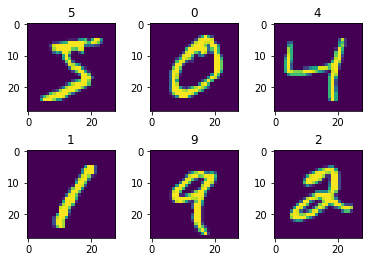

In [ ]:
# Ploting Loaded 6 images.
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i)
    ax.imshow(X_6[i-1].squeeze())
    ax.set_title(y_6[i-1])

In [ ]:
# Importing all the images as train and test data.
X_train = read_image_file('/content/drive/MyDrive/Colab Notebooks/Datafiles/train-images-idx3-ubyte.gz', 60000)
y_train = read_label_file('/content/drive/MyDrive/Colab Notebooks/Datafiles/train-labels-idx1-ubyte.gz', 60000)
X_test = read_image_file('/content/drive/MyDrive/Colab Notebooks/Datafiles/t10k-images-idx3-ubyte.gz', 10000)
y_test = read_label_file('/content/drive/MyDrive/Colab Notebooks/Datafiles/t10k-labels-idx1-ubyte.gz', 10000)

# Shape of train and test
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
# Conveting all the 28*28 pixels into 784 features by reshaping all the images.
X_train = X_train.reshape(60000, 28*28)
X_test = X_test.reshape(10000, 28*28)

# Shape of dataset after reshaping
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [ ]:
# It is mandatory before applying PCA to convert mean=0 and standard deviation =1 for each variable.

scalar = StandardScaler()
std_X_train = scalar.fit_transform(X_train)

X_test = scalar.transform(X_test)

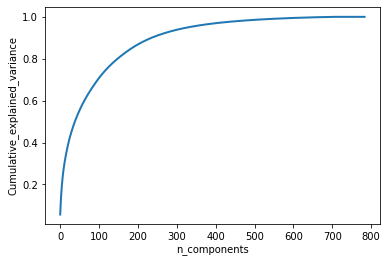

In [ ]:
# using SKlearn importing PCA for dimensionality redcution
pca = PCA()
pca.n_components = 784

pca_data = pca.fit_transform(std_X_train)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

# Plotting the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.plot(cum_var_explained, linewidth=2)
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()
# If we take 250-dimensions, approx. 90% of variance is expalined.

In [ ]:
# Reducing the dimension to 250 fetures using 
n_components = 250
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(std_X_train)

X_train = pca.transform(std_X_train)
X_test = pca.transform(X_test)

### **K-Nearest Neighbor Classification**

In [ ]:
# taking 10% of the training data and use that for validation
(trainData, valData, trainLabels, valLabels) = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Checking sizes of each data split
print("training data points: {}".format(trainLabels.shape))
print("validation data points: {}".format(valLabels.shape))
print("testing data points: {}".format(y_test.shape))


training data points: (54000,)
validation data points: (6000,)
testing data points: (10000,)


In [ ]:
# initialize the values of k for our k-Nearest Neighbor classifier 
kVals = range(1, 15, 3)
accuracies = []

# loop over kVals
for k in range(1, 15, 3):
    # train the classifier with the current value of `k`
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(trainData, trainLabels)

    # evaluate the model and print the accuracies list
    score = model.score(valData, valLabels)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)

k=1, accuracy=92.47%
k=4, accuracy=91.78%
k=7, accuracy=92.00%
k=10, accuracy=91.37%
k=13, accuracy=91.10%


In [ ]:
# largest accuracy
i = np.argmax(accuracies)
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i], accuracies[i] * 100))

k=1 achieved highest accuracy of 92.47% on validation data


In [ ]:
# The best value of k, retrain the classifier
model = KNeighborsClassifier(n_neighbors=kVals[i])
model.fit(X_train, y_train)

# Predicting labels for the test set
predictions = model.predict(X_test)

# Evaluate performance of model for each of the digits
print("EVALUATION ON TESTING DATA")
print(classification_report(y_test, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       980
           1       0.93      0.99      0.96      1135
           2       0.94      0.88      0.91      1032
           3       0.88      0.92      0.90      1010
           4       0.93      0.92      0.92       982
           5       0.90      0.88      0.89       892
           6       0.95      0.96      0.96       958
           7       0.90      0.91      0.91      1028
           8       0.94      0.86      0.90       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



### **Support Vector Machine.**

In [ ]:
# linear model of SVC
model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# prediction
y_pred = model_linear.predict(X_test)

# confusion matrix and accuracy, precision, recall
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.942 

[[ 962    0    3    3    0    6    4    1    1    0]
 [   0 1117    4    2    0    2    2    2    6    0]
 [   9    8  968    7    7    2    7    7   15    2]
 [   5    1   11  947    1   15    2    9   18    1]
 [   1    0   10    3  937    0    5    4    6   16]
 [   9    4    4   35    5  803    6    1   22    3]
 [  10    2   11    1    9   10  914    0    1    0]
 [   1    4   27    6    7    1    0  959    2   21]
 [   6    6    9   20    9   23    7    8  884    2]
 [   4    9    2   11   23    2    0   23    6  929]]


In [ ]:
#precision, recall and f1-score
scores=metrics.classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(scores)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.92      0.94      0.93      1032
           3       0.91      0.94      0.93      1010
           4       0.94      0.95      0.95       982
           5       0.93      0.90      0.91       892
           6       0.97      0.95      0.96       958
           7       0.95      0.93      0.94      1028
           8       0.92      0.91      0.91       974
           9       0.95      0.92      0.94      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [ ]:
# non-linear model using poly kernel, C=1, default value of gamma
non_linear_model_poly = SVC(kernel='poly')
non_linear_model_poly.fit(X_train, y_train)

# prediction
y_pred = non_linear_model_poly.predict(X_test)

# confusion matrix and accuracy, precision, recall
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.8942 

[[ 954    8    0    3    0    3    6    0    6    0]
 [   0 1128    2    0    0    0    4    0    1    0]
 [  10   89  848   32    7    0    2    7   36    1]
 [   1   55    5  912    2    4    4    5   17    5]
 [   0   50    4    2  898    1    2    0    3   22]
 [   3   96    3   42    3  696    7    1   35    6]
 [   9   48    4    0    5   11  872    0    9    0]
 [   2   76    9    5   15    0    0  847    2   72]
 [   3   39    3    9    6    9    3    3  892    7]
 [   4   50    4    9   26    1    0   12    8  895]]


In [ ]:
# precision, recall and f1-score
scores=metrics.classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(scores)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       980
           1       0.69      0.99      0.81      1135
           2       0.96      0.82      0.89      1032
           3       0.90      0.90      0.90      1010
           4       0.93      0.91      0.92       982
           5       0.96      0.78      0.86       892
           6       0.97      0.91      0.94       958
           7       0.97      0.82      0.89      1028
           8       0.88      0.92      0.90       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.89     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.91      0.89      0.90     10000



In [ ]:
# non-linear model using rbf kernel, C=1, default value of gamma
non_linear_model = SVC(kernel='rbf')
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

# confusion matrix and accuracy, precision, recall
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.9591 

[[ 958    0    3    3    1    6    7    1    1    0]
 [   0 1125    3    0    1    1    4    1    0    0]
 [   5    1  993    5    3    1    4    5   14    1]
 [   0    0   16  968    1    8    0   10    6    1]
 [   0    0   16    0  942    1    5    3    3   12]
 [   3    0   11   10    1  845   11    1    8    2]
 [   6    2    8    1    4    7  926    0    4    0]
 [   0    4   25    4    4    1    0  978    3    9]
 [   5    2   18    7    3   12    2    8  916    1]
 [   4    5   11   12   14    2    0   18    3  940]]


In [ ]:
#precision, recall and f1-score
scores=metrics.classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(scores)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.90      0.96      0.93      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.96      0.96       982
           5       0.96      0.95      0.95       892
           6       0.97      0.97      0.97       958
           7       0.95      0.95      0.95      1028
           8       0.96      0.94      0.95       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



### **Convolution neural network**

Explanation of the working of each layer in CNN model:
*   layer1 is Conv2d layer which convolves the image using 32 filters each of size (5*5).
*   layer2 is MaxPooling2D layer which picks the max value out of a matrix.
*   layer3 is showing Dropout at a rate of 0.2.
*   layer4 is flattening the output obtained from layer3 and this flatten output is passed to layer5.
*   layer6 is a hidden layer of neural network containng 128 neurons.
*   layer7 is the output layer having 10 neurons for 10 classes of output that is using the softmax function.

In [ ]:
# Importing all the images for CNN without any preprocessing 
X_train = read_image_file('/content/drive/MyDrive/Colab Notebooks/Datafiles/train-images-idx3-ubyte.gz', 60000)
y_train = read_label_file('/content/drive/MyDrive/Colab Notebooks/Datafiles/train-labels-idx1-ubyte.gz', 60000)
X_test = read_image_file('/content/drive/MyDrive/Colab Notebooks/Datafiles/t10k-images-idx3-ubyte.gz', 10000)
y_test = read_label_file('/content/drive/MyDrive/Colab Notebooks/Datafiles/t10k-labels-idx1-ubyte.gz', 10000)

In [ ]:
# reshaping
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [ ]:
# defining CNN model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
	model.add(MaxPooling2D())
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [ ]:
# building and ftting the model
model = baseline_model()
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
300/300 [==============================] - 30s 100ms/step - loss: 0.2440 - accuracy: 0.9291 - val_loss: 0.0864 - val_accuracy: 0.9748
Epoch 2/10
300/300 [==============================] - 29s 98ms/step - loss: 0.0707 - accuracy: 0.9790 - val_loss: 0.0472 - val_accuracy: 0.9844
Epoch 3/10
300/300 [==============================] - 30s 98ms/step - loss: 0.0495 - accuracy: 0.9850 - val_loss: 0.0406 - val_accuracy: 0.9867
Epoch 4/10
300/300 [==============================] - 30s 98ms/step - loss: 0.0406 - accuracy: 0.9875 - val_loss: 0.0362 - val_accuracy: 0.9882
Epoch 5/10
300/300 [==============================] - 30s 100ms/step - loss: 0.0310 - accuracy: 0.9908 - val_loss: 0.0328 - val_accuracy: 0.9888
Epoch 6/10
300/300 [==============================] - 30s 99ms/step - loss: 0.0261 - accuracy: 0.9917 - val_loss: 0.0345 - val_accuracy: 0.9878
Epoch 7/10
300/300 [==============================] - 29s 97ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0335 - val_accurac

CNN is primarily a good candidate for Image recognition. You could definitely use CNN for sequence data, but they shine in going to through huge amount of image and finding non-linear correlations.

SVM are margin classifier and support different kernels to perform these classificiation. Where SVM suffer is predicting the class labels when the size of the class labels is huge.

**CNN** gives higest accuracy compared to other two models.